In [168]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [169]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [170]:
def inverse_transform(tensors):
    return ((tensors.clamp(-1, 1) + 1.0) / 2.0) * 255.0

In [171]:
class DiffusionHelper:
    def __init__(self, 
                 noise_steps = 1000, 
                 beta_start = 1e-4, 
                 beta_end = 0.02,
                 img_size = 64,
                 device = "cpu"
                 ):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1 - self.beta

        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
    
    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
    
    def add_noise(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])
        sqrt_one_minus_alpha_hat = torch.sqrt(1-self.alpha_hat[t])
        eps = torch.randn_like(x)
        return sqrt_alpha_hat*x + sqrt_one_minus_alpha_hat*eps, eps
    
    def sample_timesteps(self, n):
        return torch.randint(1, self.noise_steps, size=(n,))
    
    def sample(self, model, n):
        model.eval()
        with torch.no_grad():
            # random image
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)

            for i in reversed(range(1, self.noise_steps)):
                t = torch.Tensor([i for x in range(i)]).to(self.device)
                pred_noise = model(x, t)
                alpha = self.alpha[t]
                alpha_hat = self.alpha_hat[t]
                beta = self.beta[t]
                
                noise = torch.rand_like(x) if i > 0 else torch.zeros_like(x)

                x = 1/torch.sqrt(alpha) * (x - ((1-alpha) / (torch.sqrt(1-alpha_hat[t]))) * pred_noise) + torch.sqrt(beta) * noise
        
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x *= 255
        
        return x.type(torch.uint8)

In [172]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c, mid_c=None, residual=False):
        super(DoubleConv, self).__init__()
        self.residual = residual
        if not residual:
            mid_c = out_c
        
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_c, mid_c, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_c),
            nn.GELU(),
            nn.Conv2d(mid_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_c)
        )
    
    def forward(self, x):
        if self.residual:
            return nn.GELU()(x + self.double_conv(x))
        else:
            return self.double_conv(x)

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self):
        super(SelfAttention, self).__init__()
    
    def forward(self, x):
        return x

In [173]:
class DownSample(nn.Module):
    def __init__(self, in_c, out_c, emb_dim=256):
        super(DownSample, self).__init__()
        self.down_samp = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_c, in_c, residual=True),
            DoubleConv(in_c, out_c)
        )

        self.embedding_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_c
            )
        )
    
    def forward(self, x, t):
        x = self.down_samp(x)
        embedding = self.embedding_layer(t).repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + embedding

In [174]:
class SelfAttention:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size

In [175]:
class UpSample(nn.Module):
    def __init__(self, input_size, output_size, emb_dim=256):
        super(UpSample, self).__init__()

        self.upsamp = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(input_size, input_size, residual=True),
            DoubleConv(input_size, output_size, input_size//2)
        )

        self.embedding = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                output_size
            )
        )

    def forward(self, x, skip_x, t):
        

In [176]:
class UNet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 3, time_dim = 256, device = "cpu"):
        super(UNet, self).__init__()
        self.device = device
        self.in_channels = DoubleConv(in_channels, 64)
        self.down1 = DownSample(64, 128)
        self.sa1 = SelfAttention(128, 32)
        self.down2 = DownSample(128, 256)
        self.sa2 = SelfAttention(256, 16)
        self.down3 = DownSample(256, 256)
        self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = UpSample(512, 128)
        self.sa4 = SelfAttention(128, 16)
        self.up2 = UpSample(256, 64)
        self.sa5 = SelfAttention(64, 32)
        self.up3 = UpSample(128, 64)
        self.sa6 = SelfAttention(64, 64)
        self.out_channels = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2, device=self.device).float()/channels))
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.in_channels(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.out_channels(x)
        return output


In [177]:
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms

transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Lambda(lambda t: (t * 2) - 1)
        ]
    )


dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transforms)

Files already downloaded and verified


In [178]:
dataloader = DataLoader(dataset, batch_size=32, 
                            shuffle=True
                           )
vis_loader = DataLoader(dataset, batch_size=6, 
                            shuffle=True
                           )

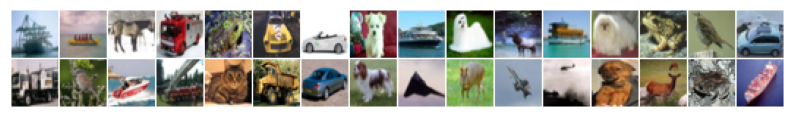

In [179]:
from torchvision.utils import make_grid
 
plt.figure(figsize=(10, 4), facecolor='white')
 
for b_image, _ in dataloader:
    b_image = inverse_transform(b_image)
    grid_img = make_grid(b_image / 255.0, nrow=16, padding=True, pad_value=1)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis("off")
    break

In [180]:
diffusion_helper = DiffusionHelper(img_size=32, device=device)

In [181]:
noisy_images = []
specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999]

images, labels = next(iter(vis_loader))

for timestep in specific_timesteps:
    timestep = torch.as_tensor(timestep, dtype=torch.long)

    xts, _ = diffusion_helper.add_noise(images, timestep)
    xts = inverse_transform(xts)

    noisy_images.append(xts)

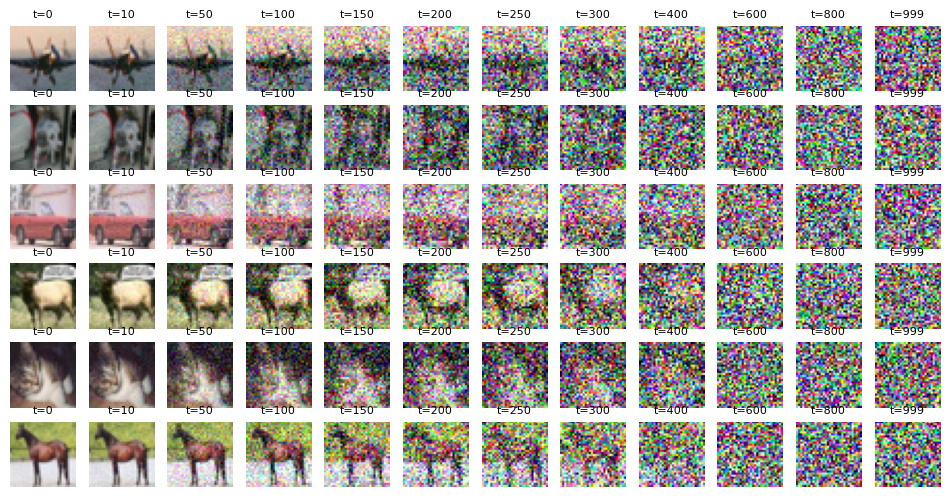

In [183]:
_, ax = plt.subplots(6, len(noisy_images), figsize=(12, 6))
 
for j, (timestep, noisy_sample) in enumerate(zip(specific_timesteps, noisy_images)):
    for i in range(len(noisy_sample)):
        ax[i][j].imshow(noisy_sample[i].permute(1, 2, 0)/255.0)
        ax[i][j].set_title(f"t={timestep}", fontsize=8)
        ax[i][j].axis("off")
        ax[i][j].grid(False)
 
plt.axis("off")
plt.show()